# Spectral Methods in Python

In [1]:
import ipywidgets
%pylab inline

Populating the interactive namespace from numpy and matplotlib


Importing the library

In [2]:
# %load cheb.py
from numpy import *
from numpy.fft import fft,ifft

def cheb(y):
    '''Chebyshev transform. Finds Chebyshev coefficients given y evaluated on
    Chebyshev grid'''
    N = len(y) - 1
    yt = real(fft(r_[y,y[-2:0:-1]]))
    yt = yt/(2*N)
    yt = r_[yt[0],yt[1:N]+yt[-1:N:-1],yt[N]]

    return yt

def icheb(c):
    '''Inverse Chebyshev transform. Evaluates Chebyshev series at the Chebyshev 
    grid points given Chebyshev coefficients.'''
    N = len(c) - 1
    y = r_[c[0],0.5*c[1:N],c[N],0.5*c[-1:N:-1]]
    y = y*2*N
    y = real(ifft(r_[y,y[-2:0:-1]]))[:N+1]

    return y


def Dcheb(y,interval):
    '''Chebyshev derivative of y evaluated on Chebyshev grid in interval [a,b]'''
    N = len(y) - 1
    a,b = interval
    x = 0.5*(b-a)*(cos(r_[0:N+1]*pi/N) + 1) + a

    k = r_[0:N]

    A = real(fft(r_[y,y[-2:0:-1]]))
    yy = real(ifft(1j*r_[k,0,-k[-1:0:-1]]*A))

    fact = 2.*(x-a)/(b-a)-1
    fact = fact[1:-1]
    yprime = -2./(b-a)*yy[1:N]/sqrt(1-fact**2)

    A = A/(2*N)
    A = r_[A[0],A[1:N]+A[-1:N:-1],A[N]]
    k = r_[0:N+1]

    yprime1 = sum(k**2*A)*2./(b-a)
    yprimeN = sum((-1)**(k+1)*k**2*A)*2./(b-a)

    return r_[yprime1,yprime,yprimeN]



def regrid(y,M):
    N = len(y) - 1
    a = cheb(y)
    if M==N:
        return y
    if M>N:
        a = r_[a,zeros(M-N)]
        return icheb(a)
    if M<N:
        a = a[:M+1]
        return icheb(a)



def clenshaw(x,c):
    '''Clenshaw algorithm to evaluate Chebyshev series at x
    assumes x is in [-1,1]'''
    N = len(c) - 1
    b = zeros(N+2)
    b[-1] = 0
    b[-2] = c[-1]
    for r in r_[N-1:0:-1]:
        b[r] = 2*x*b[r+1] - b[r+2] + c[r]
    s = x*b[1] - b[2] + c[0]

    return s


def clenshaw2(x,c,change_grid = True):
    '''Vectorized version of Clenshaw algorithm
    Use this for Chebyshev polynomial evaluation'''
    if change_grid:
    	if (min(x)!=-1) or (max(x)!=1):
        	x = 2*(x-min(x))/(max(x)-min(x)) - 1
    N = len(c) - 1
    b = zeros([N+2,len(x)])
    b[-1,:] = 0
    b[-2,:] = c[-1]
    for r in r_[N-1:0:-1]:
        b[r,:] = 2*x*b[r+1,:] - b[r+2,:] + c[r]
    s = x*b[1,:] - b[2,:] + c[0]

    return s



def chebD(c,interval):
    '''Finds derivative of Chebyshev series in spectral space
    i.e. maps c_n--->d_n where c_n,d_n are Chebyshev coefficients
    of f(x) and f'(x) in the interval [a,b].'''
    N = len(c) - 1
    a,b = interval
    if (a!=-1.) or (b!=1.):
        factor = 2./(b-a)
    else: 
        factor = 1.

    b = c*r_[0:N+1]


    cp = zeros_like(b)

    cp[0] = sum(b[1::2])

    evens = b[2::2]
    odds = b[1::2]

    cp[1:N+1-(N%2):2] = 2*cumsum(evens[-1::-1])[-1::-1]
    cp[2:N+1-((N+1)%2):2] = 2*cumsum(odds[-1::-1])[-2::-1]

    cp = cp*factor

    return cp


def chebD_semiinf(c):
    '''Finds the derivative of Chebyshev series in spectral space
    i.e. maps c_n --> d_n where c_n, d_n are Chebyshev coefficients
    of f(x) and f'(x) in the interval [0,oo)'''
    '''To be used only for the positive half-line'''
    
    N = len(c) - 1
    
    b = c*r_[0:N+1]


    cp = zeros_like(b)

    cp[0] = sum(b[1::2])

    evens = b[2::2]
    odds = b[1::2]

    cp[1:N+1-(N%2):2] = 2*cumsum(evens[-1::-1])[-1::-1]
    cp[2:N+1-((N+1)%2):2] = 2*cumsum(odds[-1::-1])[-2::-1]

    d0 = 3./4*cp[0] - cp[1]/2. + cp[2]/8.
    d1 = -cp[0] + 7./8*cp[1] - cp[2]/2. + cp[3]/8.
    d2 = cp[0]/4. - cp[1]/2. + 3./4*cp[2] - cp[3]/2. + cp[4]/8.
    d3 = cp[1]/8. - cp[2]/2. + 3./4*cp[3] - cp[4]/2. + cp[5]/8.
    
    dn = [ cp[i-2]/8. - cp[i-1]/2. + 3./4*cp[i] - cp[i+1]/2. + cp[i+2]/8.  for i in range(4,N-1)]

    dn1 = cp[N-1-2]/8. - cp[N-1-1]/2. + 3./4*cp[N-1] - cp[N-1+1]/2.
    
    dn2 = cp[N-2]/8. - cp[N-1]/2. + 3./4*cp[N]
    
    dn = r_[d0,d1,d2,d3,dn,dn1,dn2]

    return dn


def cheb2zD_semiinf(c):
    '''Finds the Chebyshev coefficients of the operator 2z df/dz when
    f has a series in Chebyshev rational functions Rn(z) = Tn((z-1)/(z+1)). Input
    is the coefficients of f.'''
    
    N = len(c) - 1
    
    b = c*r_[0:N+1]


    cp = zeros_like(b)

    cp[0] = sum(b[1::2])

    evens = b[2::2]
    odds = b[1::2]

    cp[1:N+1-(N%2):2] = 2*cumsum(evens[-1::-1])[-1::-1]
    cp[2:N+1-((N+1)%2):2] = 2*cumsum(odds[-1::-1])[-2::-1]

    d0 = -cp[2]/4. + cp[0]/2.
    d1 = cp[1]/4. - cp[3]/4.
    d2 = -cp[0]/2. + cp[2]/2. - cp[4]/4.
    
    dn = [ -cp[n-2]/4.  + cp[n]/2. - cp[n+2]/4 for n in range(3,N-1)] 
    
    dn1 = -cp[N-3]/4. + cp[N-1]/2
    dn2 = -cp[N-2]/4. + cp[N]/2
    
    dn = r_[d0,d1,d2,dn,dn1,dn2]
    
    return dn



def Intcheb(y,interval):
    '''Clenshaw-Curtis to find definite integral of function y(x) given at
    Chebyshev grid points in some interval [a,b]'''
    fact = 0.5*(interval[1]-interval[0])
    b = cheb(y)
    N = len(y) - 1
    if N%2 == 0:
        w = array([ 2./(-(2*k)**2+1) for k in r_[0:N/2+1]])
    else:
        w = array([ 2./(-(2*k)**2+1) for k in r_[0:(N-1)/2+1]])
    return dot(b[::2],w)*fact



def chebI(c,interval,x0=None,f0=None):
    if x0==None:
        x0=interval[0]

    N = len(c) - 1
    I = diag(1./(2*r_[0.5,r_[2:N+1]]),-1) -diag(1./(2*r_[1,r_[1:N]]),1)
    I[0,1] = 0
    
    factor = (interval[1]-interval[0])/2.
    
    ci = dot(I,c)*factor
    x = 2*(x0-interval[0])/(interval[1]-interval[0]) - 1
    
    if x==-1 and f0==None:
        ci[0] = -sum((-1)**r_[1:N+1]*ci[1:])
    else:
        ci[0] = f0 - clenshaw(x,ci)
    return ci



def cheb_convolve(a,b):
    '''Finds the product of two functions whose Chebyshev coefficients are 
    given by a and b. Output is the coefficiets of the product.'''

    M = len(b)
    N = len(a)
    
    if N>M:
        b = r_[b,zeros(N-M)]
        N = N - 1
    elif M>N:
        a = r_[a,zeros(M-N)]
        N = M - 1
    else:
        N = N - 1
    
    a[0] = a[0]*2.
    b[0] = b[0]*2.
        
    c0 = a[0]*b[0] + 2*dot(a[1:],b[1:])
    
    c1 = [ dot(a[0:k+1][::-1],b[0:k+1]) + dot(a[1:N-k+1],b[k+1:N+1]) + dot(a[k+1:N+1],b[1:N-k+1])  for k in range(1,N) ]

    c2 = [ dot(a[k-N:N+1][::-1],b[k-N:N+1])  for k in range(N,2*N+1)]
    
    c = r_[c0/2,c1,c2]/2.
    
    return c[:N+1]
    
def cosT(d,inverse=False):
    '''Finds the cosine transform of a given sequence'''
    b = []
    N = len(d)-1
    for n in r_[0:N+1]:
        b.append(sum(d*cos(n*r_[0:N+1]*pi/N)))
    b = array(b)
    if inverse:
        return b
    else:
        b[0] = b[0]/(N)
        b[1:] = b[1:]*2/(N)
        return b

### Heat Equation

In [21]:
N=50
x=cos(np.pi*np.linspace(0,N,N+1)/N)
y = np.sin(np.pi*x) #exp(-100*x**2)

Setting up initial and boundary conditions 

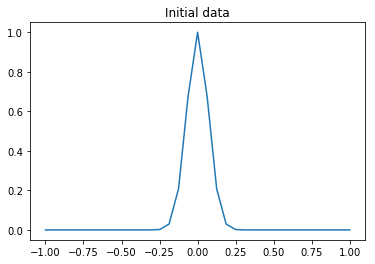

In [36]:
N=50
x=cos(np.pi*np.linspace(0,N,N+1)/N)
y =  exp(-100*x**2)  
T=20
plt.plot(x,y)
title('Initial data')

In [71]:
def uexact(x,t):
    return np.exp(-np.pi**2*t) * np.sin(np.pi*x)

def diffusion(w,interval=[-1,1]):
    return Dcheb(Dcheb(w,interval),interval)

def euler(yvec,Jac,dt,interval=[-1,1]):
    y=yvec[0]
    return y + dt*Jac(y)

def rk4(yvec,Jac,dt,interval=[-1,1]):
    y=yvec[0]
    k1= dt*Jac(y)
    k2= dt*Jac(y+k1/2)
    k3= dt*Jac(y+k2/2)
    k4= dt*Jac(y+k3)
    return y + (k1 + 2*(k2+k3) +k4)/6

def classic(figs,x,y,params):
    fig = figure()
    ax=plt.gca()
    ax.set_ylim([0, 1])
    plt.plot(x,y)
    title('Time t = %g' % params[0])
    figs.append(fig)
    close(fig)
    return figs

def heat_solve(initvec,Jac,BC,steps,dt,x,solver=euler, interval=[-1,1],plotter=classic,u=uexact):
    N=len(x)
    w=np.zeros([N,steps])
    start=0
    for init in initvec:
        w[:,start]=init
        w[0,start]=BC[0]
        w[-1,start]=BC[-1]
        start +=1
    figs=[]
    error=[]
    for i in range(start,steps):
        w[:,i]=solver([w[:,i-1],w[:,i-2]],Jac,dt)
        w[0,i]=BC[0]
        w[-1,i]=BC[-1]
        figs=classic(figs,x,w[:,i],[i*dt])
        b=w[:,i]
        p=u(x,i*dt)-b
        error.append([numpy.linalg.norm(p)])
        
    return figs,error

In [72]:
figs,error=heat_solve(y,diffusion,[0,0],100,20/N**4,x,rk4)

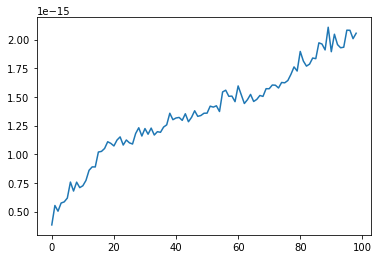

In [101]:
plt.plot(error) #rk4 error (don't run this)

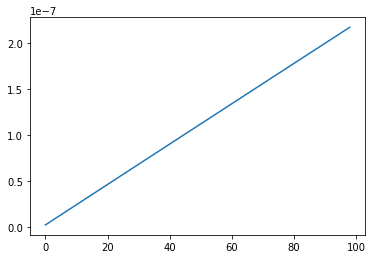

In [84]:
plt.plot(error) #Euler error (don't run this)

Implicit schemes

In [68]:
def diffmatrix(N, interval=[-1,1]):
    A=np.eye(N)
    B=np.zeros((N,N))
    i=0
    for row in A:
        B[i,:]= Dcheb(Dcheb(row,interval),interval)
        i+=1
    T=B.transpose() 
    return T

In [69]:
def bdf1(y,Jac,dt,interval=[-1,1]):
    I = np.eye(N)
    A= I-dt*Jac
    return np.linalg.solve(A, y[0])

def bdf2(yvec,Jac,dt,interval=[-1,1]):
    y1=yvec[0]
    y2=yvec[1]
    I = np.eye(N)
    A = I-(2.0/3.0)*dt*Jac
    b = (4.0/3.0)*y1 - (1.0/3.0)*y2
    return np.linalg.solve(A, b)

In [77]:
N=len(x)
T=diffmatrix(N)
figs,error=heat_solve([y,y],T,[0,0],100,20/N**4,x,bdf2)

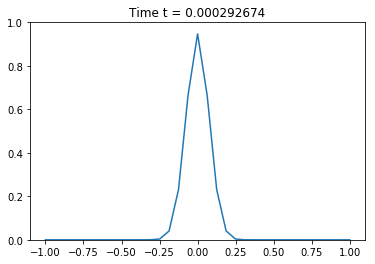

In [78]:
def display_frame(frameno): 
    display(figs[frameno])
    
widget = ipywidgets.IntSlider(min=0,max=len(figs)-1, value=0)
ipywidgets.interact(display_frame, frameno=widget)

### The wave equation


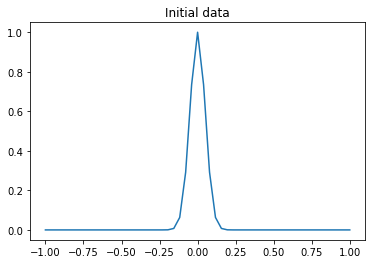

In [3]:
N=80
dt=8/N**2
T=int(4/dt)
x=np.cos(np.pi*np.linspace(0,N,N+1)/N)
w=np.zeros([N+1,T])
w[:,0]=exp(-200*x**2)
w[:,1]=exp(-200*(x-dt)**2)
interval =[-1,1]
fig = figure()
plot(x,w[:,0])
title('Initial data')
figs1=[fig]
for i in range(2,T):
    diff= Dcheb(Dcheb(w[:,i-1],interval),interval)
    #diff= chebfft(chebfft(w[:,i-1]))
    w[:,i]=2*w[:,i-1]-w[:,i-2]+(dt**2)*diff
    w[0,i]=0
    w[N,i]=0
    fig = figure()
    plot(x,w[:,i])
    tn=i*dt
    title('Time t = %g' % tn)
    figs1.append(fig)
    close(fig)

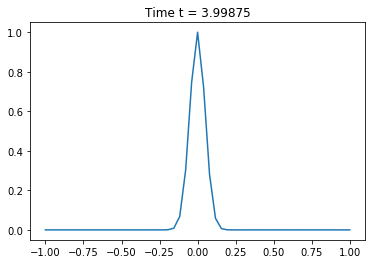

In [6]:
def display_frame1(frameno): 
    display(figs1[frameno])
widget1 = ipywidgets.IntSlider(min=0,max=len(figs1)-1, value=0)
ipywidgets.interact(display_frame1, frameno=widget1)